In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour # For active_contour function

# For active_contour function
from skimage.segmentation import chan_vese, morphological_chan_vese, checkerboard_level_set,morphological_geodesic_active_contour

# For some image filtering
from skimage.morphology import white_tophat, black_tophat, disk

import skimage.io 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [2]:
def edge_map(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.sobel(blur)

def edge_map2(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.scharr(blur)

def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius) 
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)

        
def define_initial_circle(R0,r0,c0,Nber_pts=400):
    # Define initial contour shape
    s      = np.linspace(0, 2*np.pi, Nber_pts)
    Radius = R0  
    r      = r0 + Radius*np.sin(s)
    c      = c0 + Radius*np.cos(s) #col
    init   = np.array([r, c]).T
    return init


## Create slides for animation
def animate_cv(image, segs, interval=1000):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray');
    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    ax.axis('off')

    def init():
        im.set_data(segs[0])
        return [im]

    def animate(i):
        im.set_array(segs[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim


def animate_snake(image, segs, interval=500):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray');
    #    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    #ax.plot(segs[0][:, 1], segs[0][:, 0], '--r', lw=3)
    ax.axis('off')
    line, = ax.plot([], [], '-r', lw=2)

    def init():
        line.set_data(segs[0,:,1],segs[0,:,0])
        return [line,]

    def animate(i):
        line.set_data(segs[i,:,1],segs[i,:,0])
        return [line,]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim



###########################
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

# Read images

This cell reads a series of images that you can then use in various tests. <br>
Note that some images are provided with ground-truth masks of structures of interest:<br>
1. OCT_myocardium/case272.tif [one image]
2. images_blood_cells/000016.png [several images available]


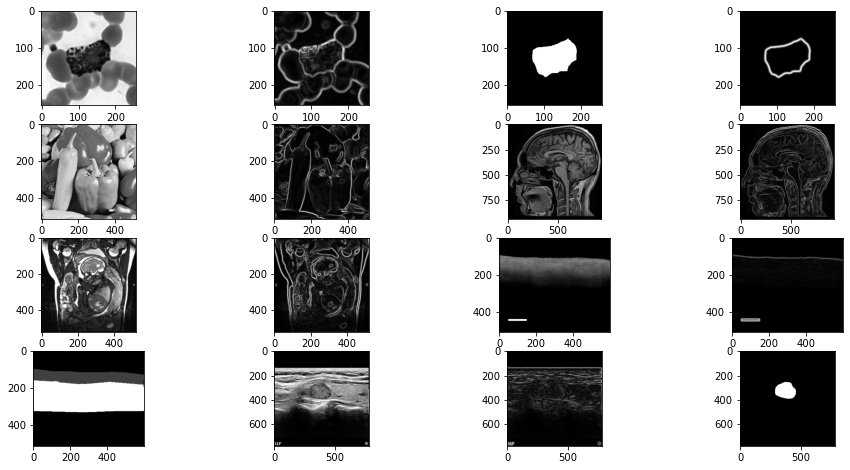

In [3]:
# import warnings
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

img_star          = skimage.io.imread('./images_misc/smooth_star.png', as_gray = True)
img_star_noisy    = skimage.io.imread('./images_misc/smooth_star_noisy.png', as_gray = True)

img_hela    = skimage.io.imread('./images_misc/hela_big_gt.png', as_gray = True)
edge_hela   = edge_map(img_hela, sigma=2)

img_pepper  = skimage.io.imread('./images_misc/peppers_gt.png', as_gray = True)
edge_pepper = edge_map(img_pepper, sigma=2)
img_pepper  = img_pepper.astype('float64')

img_MRIb  = skimage.io.imread('./images_misc/MRI_brain_sag.png', as_gray = True)
edge_MRIb = edge_map(img_MRIb, sigma=2)
img_MRIf  = skimage.io.imread('./images_misc/MRI_fetus.png', as_gray = True)
edge_MRIf = edge_map(img_MRIf, sigma=2)


img_cell  = skimage.io.imread('./images_blood_cells/000016.png', as_gray = True)
edge_cell = edge_map(img_cell, sigma=2)
#skimage.io.imshow(img_cell)

img_mask = skimage.io.imread('./masks_blood_cells/000016.png', as_gray = True)
edge_mask = edge_map(img_mask, sigma=2)
# skimage.io.imshow(img_mask)

img_OCT  = skimage.io.imread('./OCT_myocardium/case272.tif', as_gray = True)
edge_OCT = edge_map(img_OCT, sigma=2)
labels_OCT = skimage.io.imread('./OCT_myocardium/case272_label.tiff', as_gray = True)


img_nodule = skimage.io.imread('./thyroid_nodule/1074.png', as_gray = True)
edge_nodule = edge_map(img_nodule, sigma=2)
labels_nodule = skimage.io.imread('./thyroid_nodule/1074_mask.png', as_gray = True)


fig, axes = plt.subplots(4,4, figsize=(16, 8))
ax = axes.ravel()
ax[0].imshow(img_cell, cmap=plt.cm.gray);
ax[1].imshow(edge_cell, cmap=plt.cm.gray);
ax[2].imshow(img_mask, cmap=plt.cm.gray);
ax[3].imshow(edge_mask, cmap=plt.cm.gray);
ax[4].imshow(img_pepper, cmap=plt.cm.gray);
ax[5].imshow(edge_pepper, cmap=plt.cm.gray);
ax[6].imshow(img_MRIb, cmap=plt.cm.gray);
ax[7].imshow(edge_MRIb, cmap=plt.cm.gray);
ax[8].imshow(img_MRIf, cmap=plt.cm.gray);
ax[9].imshow(edge_MRIf, cmap=plt.cm.gray);
ax[10].imshow(img_OCT, cmap=plt.cm.gray);
ax[11].imshow(edge_OCT, cmap=plt.cm.gray);
ax[12].imshow(labels_OCT, cmap=plt.cm.gray);
ax[13].imshow(img_nodule, cmap=plt.cm.gray);
ax[14].imshow(edge_nodule, cmap=plt.cm.gray);
ax[15].imshow(labels_nodule, cmap=plt.cm.gray);

# Image properties: 
## Range of values and data type matter ...


Some routines won't work if your image type is int8 or uint8...
Here is how to check your image data type

And regularly check your image content in terms of:
* intensities range of values
* distributions of intensities via its histogram


float64
0.04579333333333333
255.0


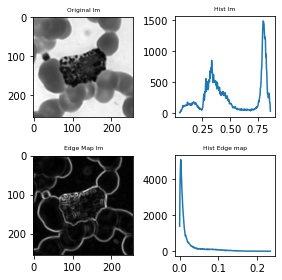

In [4]:

img_test  = img_cell
Sigma_val = 1
edge_test = edge_map(img_test, sigma=Sigma_val)


## Print some basic image properties
print(img_test.dtype)
print(np.min(img_test))
print(np.max(img_pepper))


## Show Hist
hist_test, bins_test             = np.histogram(img_test.flatten(), bins=256)
hist_edge_test, bins_edges_test  = np.histogram(edge_test.flatten(), bins=256)

fig, axes = plt.subplots(2,2, figsize=(4, 4))
ax        = axes.ravel()
ax[0].imshow(img_test, cmap=plt.cm.gray);
ax[0].set_title("Original Im", fontsize=6);
ax[1].plot(bins_test[0:-1],hist_test);
ax[1].set_title("Hist Im", fontsize=6);
ax[2].imshow(edge_test, cmap=plt.cm.gray);
ax[2].set_title("Edge Map Im", fontsize=6);
ax[3].plot(bins_edges_test[0:-1],hist_edge_test);
ax[3].set_title("Hist Edge map", fontsize=6);
fig.tight_layout()
plt.show();



# Edge maps
Deformable models rely on edge maps. Most routines have their own strategy coded to compute the edge map. 

* Edge maps usually involve smoothing of the image, to be robust to noise. Make sure you understand how this is controlled in the routine you use. 
* Edge maps usually show pixels with high gradient magnitudes in white (high values)
* Most deformable model routines can be fed directly with an Edge Map rather than the original image as its input
* Some routine expect to be fed with an inverse edge map where high gradient locations have small values, to stop the contour via a velocity set to ~zero. 

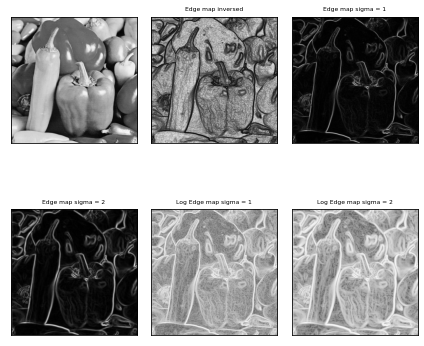

In [5]:

img_to_test = img_pepper

# Classic Edge map with Gaussian smoothing controled by sigma
edge_test1         = edge_map(img_to_test, sigma=1)
edge_test1_l       = np.log2(edge_test1)
edge_test2         = edge_map(img_to_test, sigma=2)
edge_test2_l       = np.log2(edge_test2)

# Inversed Edge map
# Returns Edge map = 1.0 / np.sqrt(1.0 + alpha * gradnorm)
edge_inv_test  = skimage.segmentation.inverse_gaussian_gradient(img_to_test, alpha=1.0, sigma=1.0) 


fig, axes = plt.subplots(2,3, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(img_to_test, cmap=plt.cm.gray);
ax[1].imshow(edge_inv_test, cmap=plt.cm.gray);
ax[1].set_title("Edge map inversed", fontsize=6);
ax[2].imshow(edge_test1, cmap=plt.cm.gray);
ax[2].set_title("Edge map sigma = 1", fontsize=6);
ax[3].imshow(edge_test2, cmap=plt.cm.gray);
ax[3].set_title("Edge map sigma = 2", fontsize=6);
ax[4].imshow(edge_test1_l, cmap=plt.cm.gray);
ax[4].set_title("Log Edge map sigma = 1", fontsize=6);
ax[5].imshow(edge_test2_l, cmap=plt.cm.gray);
ax[5].set_title("Log Edge map sigma = 2", fontsize=6);

for i in range(0,6):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

fig.tight_layout()
plt.show();

# Test some image manipulations

Let you test some image transformations based on morphological operators and histogram manipulation. 
When transforming image contrast, it is always interesting to look at the differences between the original image and the transformed version.

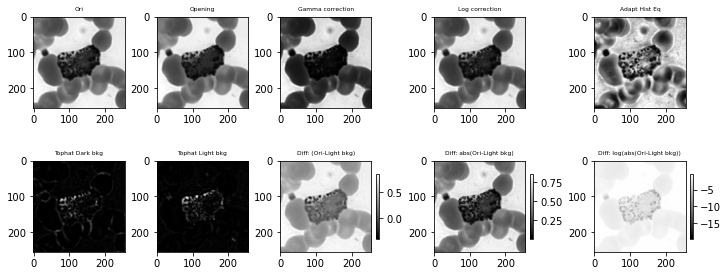

In [6]:
img_ori_to_test = img_cell
img_to_test     = img_ori_to_test

PRE_ENHANCE     = 1
OPTION_ENHANCE  = 0 # can be 0 (nothing) to 4

# Run all  OPTION_ENHANCE for display here       
gamma_corrected       = skimage.exposure.adjust_gamma(img_to_test, 2)
logarithmic_corrected = skimage.exposure.adjust_log(img_to_test, gain= 1,inv=True)
img_open              = skimage.morphology.diameter_opening(img_to_test, 40, connectivity=2)
img_adapteq           = skimage.exposure.equalize_adapthist(img_to_test, clip_limit=0.03)

# PRE ENHANCEMENT OPTIONS:
if PRE_ENHANCE==1:
    if OPTION_ENHANCE==1:
        # Gamma
        img_to_test     = gamma_corrected
    elif OPTION_ENHANCE==2:
        # Logarithmic (O = gain*log(1 + I)) or if Inv (O = gain*(2**I - 1))
        img_to_test           = logarithmic_corrected
    elif OPTION_ENHANCE==3:
        # Morpho Opening
        img_to_test           = img_open
elif OPTION_ENHANCE==4:
        # Contrast Limited Adaptive Histogram Equalization (CLAHE).
        img_to_test           = img_adapteq

# Enhance details either dark around light background of vice versa with the Top-Hat transform
Radius_val = 5
img_test1  = subtract_background(img_to_test, radius=Radius_val, light_bg=False)
img_test2  = subtract_background(img_to_test, radius=Radius_val, light_bg=True)

# SHOW OUTPUTS
fig, axes = plt.subplots(2,5, figsize=(10, 4),constrained_layout=True)
ax        = axes.ravel()
Shrink_factor_colormap = 0.5
ax[0].imshow(img_ori_to_test, cmap=plt.cm.gray);
ax[0].set_title("Ori", fontsize=6);

ax[1].imshow(img_open, cmap=plt.cm.gray);
ax[1].set_title("Opening", fontsize=6);
ax[2].imshow(gamma_corrected, cmap=plt.cm.gray);
ax[2].set_title("Gamma correction", fontsize=6);
ax[3].imshow(logarithmic_corrected, cmap=plt.cm.gray);
ax[3].set_title("Log correction", fontsize=6);
ax[4].imshow(img_adapteq, cmap=plt.cm.gray);
ax[4].set_title("Adapt Hist Eq", fontsize=6);

ax[5].imshow(img_test1, cmap=plt.cm.gray);
ax[5].set_title("Tophat Dark bkg", fontsize=6);
ax[6].imshow(img_test2, cmap=plt.cm.gray);
ax[6].set_title("Tophat Light bkg", fontsize=6);

tmp_show = ax[7].imshow(img_to_test-img_test2, cmap=plt.cm.gray);
ax[7].set_title("Diff: (Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[7], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[8].imshow(abs(img_to_test-img_test2), cmap=plt.cm.gray);
ax[8].set_title("Diff: abs(Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[8], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[9].imshow(np.log2(abs(img_to_test-img_test2)), cmap=plt.cm.gray);
ax[9].set_title("Diff: log(abs(Ori-Light bkg))", fontsize=6);
plt.colorbar(tmp_show,ax=ax[9], shrink=Shrink_factor_colormap, location='right')

#fig.tight_layout() # not compatible with option constrained_layout=True in plt.subplots needed to display the colorbar
plt.show();


# Seg #1: 
### Snake on a binary shape

Based on the routine **active_contour** from skimage. <br>
Default **parameter values** are: <br>
* alpha=0.01  (Snake length shape parameter. Higher values makes snake contract faster.)
* beta=0.1    (Snake smoothness shape parameter. Higher values makes snake smoother.)
* gamma=0.01  (Explicit time stepping parameter - Equivalent to the viscosity of the environment)
* max_px_move=1.0
<br>

There are two **other parameters** that define the final image information used to define external forces used to define regions.img = w_line x img + w_edge x edge: <br> 
*   w_line_val= 0 (default) | =1 if want to input_edge map directly. Use negative values to attract toward dark 
*   w_edge_val= 1 (default)  | = 0 if do not want to use internal edge map. Use negative values to repel snake from edges

 
## TODO:
1. Run the cell for **img_to_seg=img_mask** with the sets of parameter values provided. 1st set uses values by default, 2nd-3rd sets use custom values to help improve the smoothness of the final contour. <br>
    1. Comment on defaults seen on the obtained initial segmentations. <br>
    1. Explain why you think increasing the gamma_val has better helped smooth the final contour.  <br>

2. Test now by using a small initial circle inside the white shape. What is happening and what additional force seen in the class could help fixing this issue?

3. Now run the segmentation on the **img_to_seg=img_star** or **img_to_seg=img_star_noisy**. Try the same parameter values adjustments as before to get a smoother final contour. Comment on the issues observed with the two options.
4. BONUS: there is a way to obtain a "perfect" segmentation for the star shape. Propose one solution which might involve many more iterations, once you have checked with few iterations that behavior is stable.


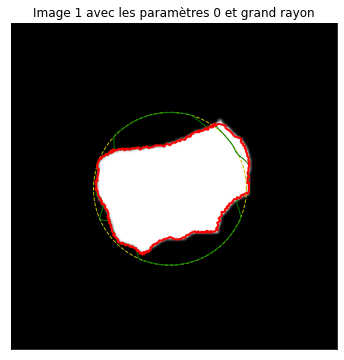

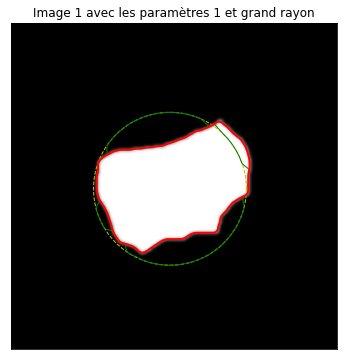

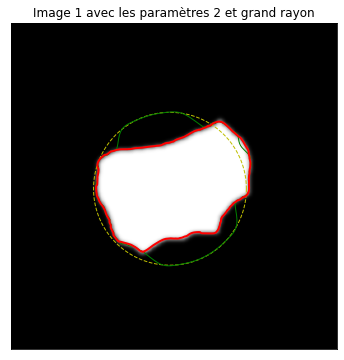

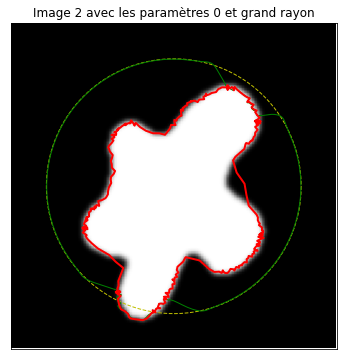

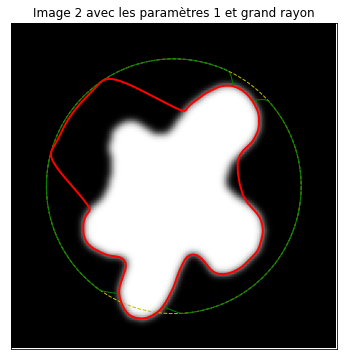

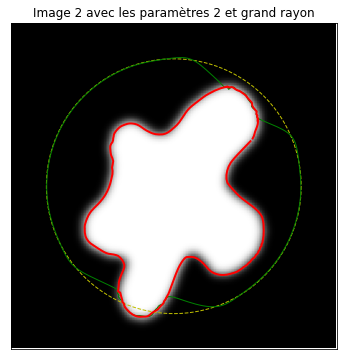

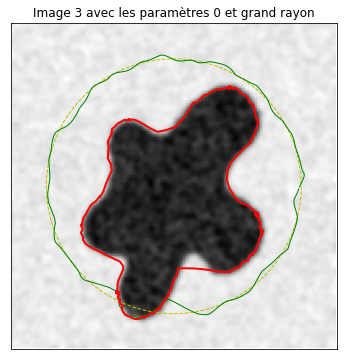

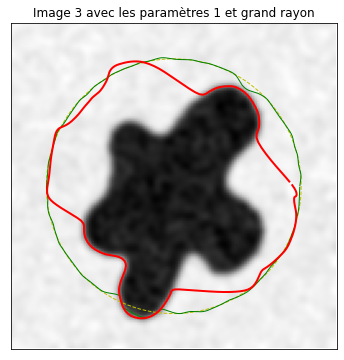

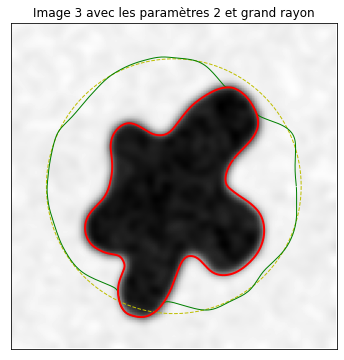

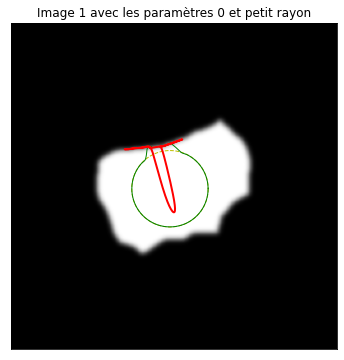

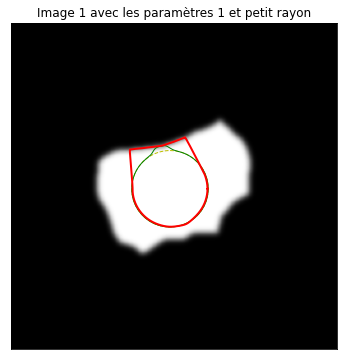

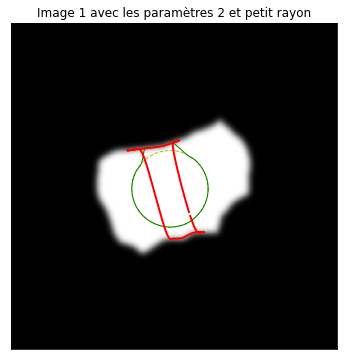

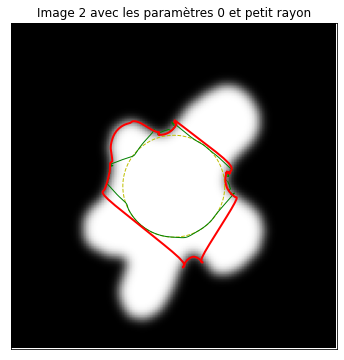

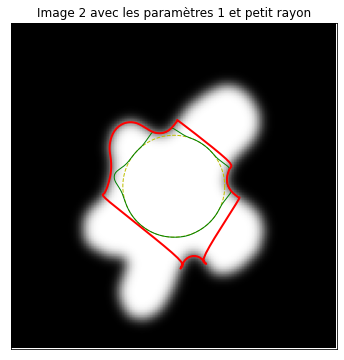

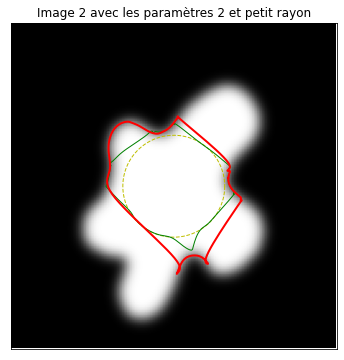

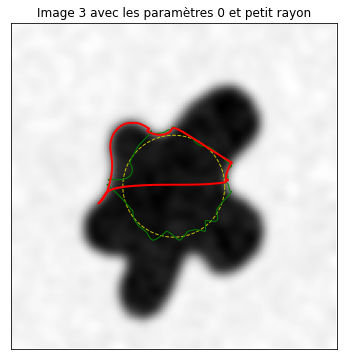

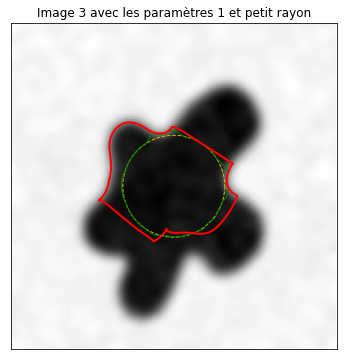

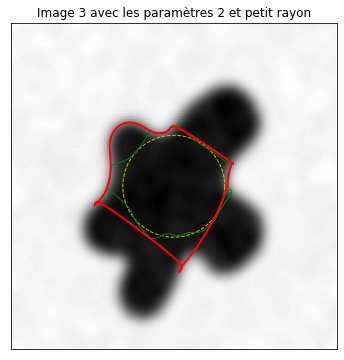

In [7]:
img_to_seg = []

# 1ST image
img_to_seg.append(img_mask);

# 2ND and 3RD image
img_to_seg.append(img_star);
img_to_seg.append(img_star_noisy);

#Parameters
r0 = [130, 64, 64]
c0 = [125, 64, 64]
R0 = [[60, 50, 50], [30, 20, 20]]
alpha_val = 0.01
beta_val = [0.1, 0.1, 1]
gamma_val = [0.01, 0.1, 0.01]
Niter_snake = 800
convergence_val = 1e-4 
for radius in range(2):
    for image in range(3):
        for parameters in range(3):
            # Initialise contour 
            init = define_initial_circle(R0[radius][image],r0[image],c0[image])

            # Pre-smooth the image 
            Niter_smooth    = 1
            img_to_seg[image] = gaussian(img_to_seg[image], Niter_smooth, preserve_range=False)

            # Run active contour 
            snake10 = active_contour(img_to_seg[image],
                                   init, max_iterations=10, convergence=convergence_val, 
                                     alpha=alpha_val, beta=beta_val[parameters], gamma=gamma_val[parameters])
            snake_max = active_contour(img_to_seg[image],
                                   init, max_iterations=Niter_snake, convergence=convergence_val, 
                                       alpha=alpha_val, beta=beta_val[parameters], gamma=gamma_val[parameters])

            # Display results 
            fig, ax = plt.subplots(figsize=(6, 6));
            plt.title(f'Image {image+1} avec les paramètres {parameters} et {"grand" if radius==0 else "petit"} rayon')
            ax.imshow(img_to_seg[image], cmap=plt.cm.gray);
            ax.plot(init[:, 1], init[:, 0], '--y', lw=1);
            ax.plot(snake10[:, 1], snake10[:, 0], '-g', lw=1);
            ax.plot(snake_max[:, 1], snake_max[:, 0], '-r', lw=2);
            ax.set_xticks([]), ax.set_yticks([]);
            ax.axis([0, img_to_seg[image].shape[1], img_to_seg[image].shape[0], 0]);

plt.show();

# ANSWERS
## 1.
    A.
On the obtained initial segmentations, we see some defaults as a very rough and irregular contour and also a contour that does not follow completely right the real shape of the object.

    B.
Increasing gamma allows the each iteration to differ more from the precedent and so to converge faster to the result.
## 2.
Using a small circle inside the shape as initiation, we clearly see that the contour skip and does not contains a big part of the shape. We can add an internal force in order to have a final result that will "stick" to the real contour, obtained as an equilibrium of the external and internal forces.
## 3.
With the image of the star, with the big circle and the 2nd set of parameters, the final result seems really good, but with differents parameters, we have the same problems as before.

# Seg #2: 
### Snake on a real image 

We are using here **img_to_seg   = img_cell** for which you have a ground truth mask of the target segmentation for the dark cell.  

## TODO
1. **Segment left cell**: 
    1. Run with the proposed initialisation and see that the active contour can be initialised inside the object. Give some intuition on why. 
2. **Segment right cell**:
    1. Run with the proposed initialisation and see that the active contour cannot be initialised inside the object now. Give some intuition on why.
    2. Change the parameter **Niter_smooth** while keeping snake parameters constant and give an intuition on why the final contour evolves as seen. 
    1. Change the initial contour parameters to obtain a perfect segmentation. 
3. BONUS: If you know that you are aiming for the darkest cell in the image, propose an automated initialisation of the initial active contour parameters [r0 ; c0; R0 ] that works on this image.



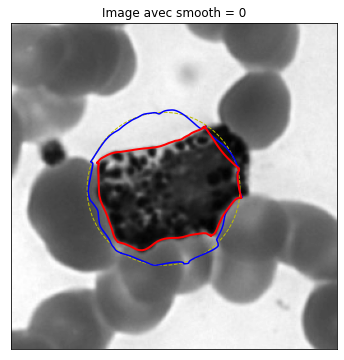

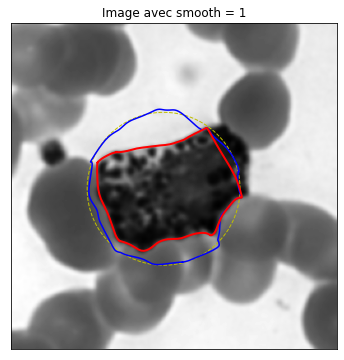

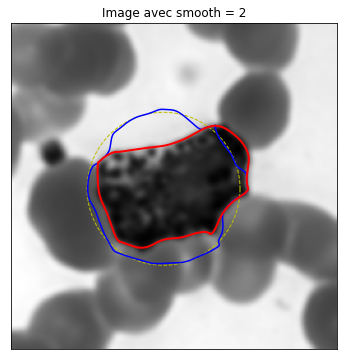

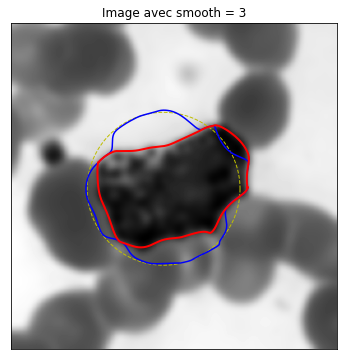

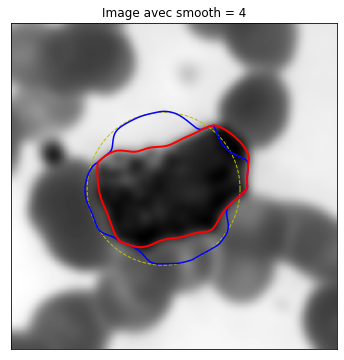

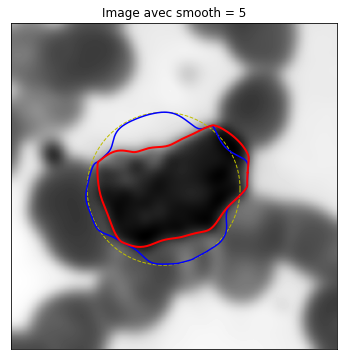

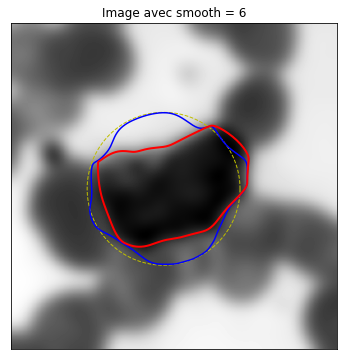

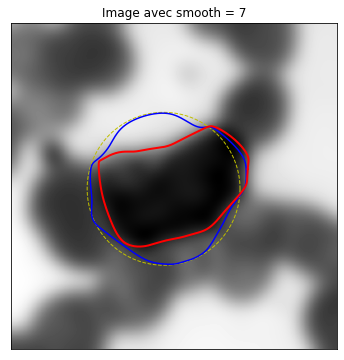

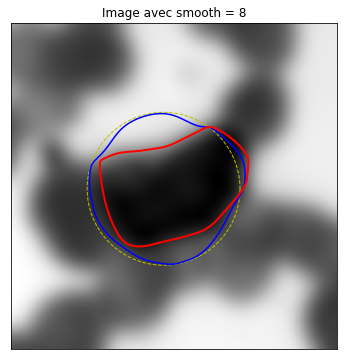

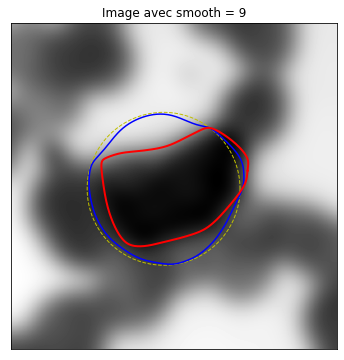

In [8]:

# Input image and parameter values
img_to_seg   =  img_cell;

# 1st SEG: To segment left cell
#r0 = 150; c0=50; R0 = 30
#alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 60 
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 800;


for smooth in range(10):
    # Pre smooth the image
    Niter_smooth = smooth
    img_to_seg_smooth = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


    # Initialise contour 
    init = define_initial_circle(R0,r0,c0)

    # Run active contour 
    snake30 = active_contour(img_to_seg_smooth,
                           init, max_iterations=30, convergence=convergence_val, 
                             alpha=alpha_val, beta=beta_val, gamma=gamma_val)
    snake = active_contour(img_to_seg_smooth,
                           init, max_iterations=Niter_snake, convergence=convergence_val, 
                           alpha=alpha_val, beta=beta_val, gamma=gamma_val)

    # Display results 
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.title(f'Image avec smooth = {smooth}')
    ax.imshow(img_to_seg_smooth, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
    ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
    ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img_to_seg_smooth.shape[1], img_to_seg_smooth.shape[0], 0])

plt.show();

Text(0.5, 1.0, 'Image avec radius = 50')

([], [])

(0.0, 256.0, 256.0, 0.0)

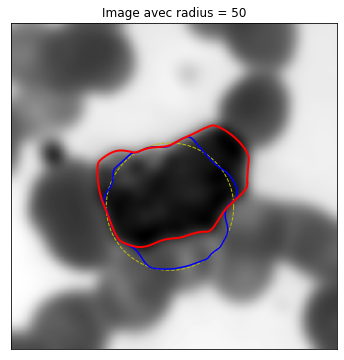

In [9]:
# import the necessary package
import cv2

R0 = 50
image_to_seg = img_cell
# apply a Gaussian blur to the image then find the darkest region
blur = gaussian(image_to_seg, R0//2, preserve_range=False)
img_to_seg_smooth = gaussian(image_to_seg, 5, preserve_range=False)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(blur)
c0, r0 = minLoc
init = define_initial_circle(R0,r0,c0)
# Run active contour 
snake30 = active_contour(img_to_seg_smooth,
                       init, max_iterations=30, convergence=convergence_val, 
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg_smooth,
                       init, max_iterations=Niter_snake, convergence=convergence_val, 
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, ax = plt.subplots(figsize=(6, 6))
plt.title(f'Image avec radius = {R0}')
ax.imshow(img_to_seg_smooth, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg_smooth.shape[1], img_to_seg_smooth.shape[0], 0])

# ANSWERS
## 1.
With real picture, the inside initialisation works quite fine. It might be because the shape is lighter and lighter in color the closer you get to the edges so at each iteration the snake is more easily "pushed" into the internal contours of the shape.
## 2.
    A.
For the 2nd cell, the inside looks way more composite than the previous one, with a lot of spots inside the cell. This cause a difficulty to recognise the real edge of the entire cell.
    
    B.
Increasing the **Niter_smooth** parameter can erase (by blurring) the spots inside the cell and that helps detecting the real edge of the cell, even if it blurs the whole image.

    C.
By changing the radius **R0** to 60 and **Niter_smooth** to 3, we have a snake that almost conforms perfectly the edges of the shape.
## 3.
As seen on the 2nd program, we can find an algorithm that is able to find the init circle for ourselves if we know that the cell to detect is the darkest cell of the image. The only problem with my code is that we still need to roughly know the size of the cell in order to give the approximate radius **R0**.

Thus, it manages to find **r0** and **c0**, the coordinate of the center of the circle, by using the **cv2.minMaxLoc** function over a gaussian-filtered image, in order to erase the noise of high frequency.

# Seg # 3

### A tool to visualise the deformations of the snake


## TO DO:
1. **Segment left cell**:
    1. Provide your comments on the deformation pattern of the snake. 
    1. Why iteration time steps get slower over iterations when initialising from the inside? 
1. **Segment right cell**:
     1. Use your optimal parameters from previous cell and comment on the deformation patterns.

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


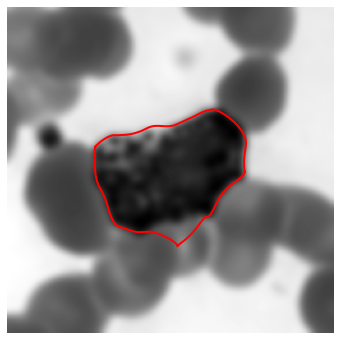

In [15]:
img_to_seg        = img_cell

# 1st SEG: To segment left cell
#r0 = 150; c0=50; R0 = 30
#alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 60
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# Pre smooth the image
Niter_smooth = 3
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour 
init = define_initial_circle(R0,r0,c0)


# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_iterations=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

# ANSWERS
## 1.
    A.
The snake deforms itself progressively, mainly one small part at each iteration, and that makes a progress all along the left side of the cell. It actually detect quite quickly the top and botom edges, but struggles with the left and right sides, even if the left side is quite contrasted.
    
    B.
By beginning with an inside circle, iteration time steps get slower over iterations because the snake is restricted by an elastic force that tends to limit its extension, while the gradient inside the cell does not change a lot while staying inside the cell.

## 2.
As in 1.A., the snake detects quite quickly the edges wich are not the most constrasted (here its the left and right edges) and after it looks like a rubber band that progressively sticks to the top edge.

# Seg # 4

### Snake with  Gradient Vector Flow (GVF)
This implementation of the GVF is performed by computing the edge map, diffusing the gradient over the whole image and directly input the GVF_edge_map to be used as external forces by setting w_line=1 and w_edge=0 in the active_contour function.

## TODO: 

1. Compare results when segmenting the Edge_map or GVF_map as input to the active_contour routine on 3 images: img_star, img_star_noisy and an image of your choice. Comment on robustness and speed differences. 
1. When using GVF_map, test the effect of decreasing by a factor of 10 alpha,beta or gamma and interpret the effect.

................................................................................................................................................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


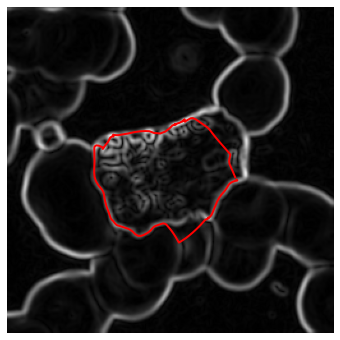

In [26]:
import gvf_elsa2
from gvf_elsa2 import  gradient_field, gradient_vector_flow


# Image to seg
#img_to_seg = img_star
#r0 = 64; c0=64; R0 = 50

# Example of another image to test. 
# NB: play with regularisation  parameter mu for gradient_vector_flow on real images
img_to_seg        = img_cell
r0 = 130; c0=120; R0 = 50 # initialise inside

alpha_val  = 0.01 ; beta_val = 0.01; gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 200; 


# Initialise contour 
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(Edge_map)
gx, gy = gradient_vector_flow(fx, fy, mu=2)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_iterations=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

# ANSWERS
## 1.
The process is faster but not as accurate as before.

## 2.
When we decrease gamma, the snake is not smooth anymore. When we decrease beta, the external force is less strong and the bottom part of the snake does not follow the actual edge.

# Seg # 5:

### The active contour with fixed end points
You will now run the active_contour with the option to maintain some points from the inital contour fixed. You are working now with the img_nodule which is an ultrasound showing different layers of tissue under the skin surface.

## TO DO:
* Write a loop to vary the initial line vertical position by few pixels and propose a method to aggregate final contours, like for example a probability edge map. 
* BONUS: Propose and implement a metric to measure the "quality" of the segmented contour, as being representative of the "interface" between two tissues. 


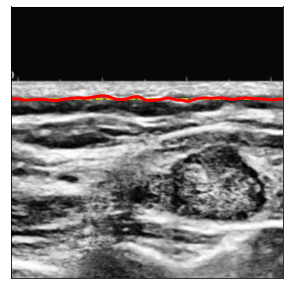

In [28]:

img_to_seg = img_nodule
r_left = 170; r_right=170; c_left=0; c_right = 780
#r_left = 200; r_right=190; c_left=0; c_right = 780
#r_left = 230; r_right=210; c_left=0; c_right = 780

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 500;
w_line_val=0; w_edge_val=1

# Pre smooth the image
img_to_seg   = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour 
Nber_pts_contour = 300
r          = np.linspace(r_left, r_right, Nber_pts_contour)
c          = np.linspace(c_left, c_right, Nber_pts_contour)
init       = np.array([r, c]).T


snake = active_contour(img_to_seg,
                       init, boundary_condition='fixed-fixed',max_iterations=Niter_snake,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                       w_line=w_line_val, w_edge=w_edge_val)

fig, ax = plt.subplots(figsize=(9, 5));
ax.imshow(img_to_seg[0:500,:], cmap=plt.cm.gray);
ax.plot(init[:, 1], init[:, 0], '--y', lw=2);
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=3);
ax.set_xticks([]), ax.set_yticks([]);
ax.set(xlim=(0, 500));
plt.show();

# Seg # 6

### Your turn on proposing a motivated pipeline using the snake capabilities from the active_contour function

## TODO: 
Choose a new image in the pool provided and propose a segmentation pipeline using the active_contour approach. Options on points to work on include: <br>
* Pre filter the image as you wish
* Manually or automatically position the initial contour
* Provide one segmentation result or merge several solutions in a probability map
* Detect issues in contour shape during deformations and propose an early stop criteria. 

# Seg #7

### Test on the Geometric Level-Set formulation using the Chan-Vese model. 
Skimage provides two implementations of the Chan-Vese approach: **morphological_chan_vese** and **chan_vese**. <br>

The contours of ojects are now encoded in a level set function **Phi**.

The **initialisation** tested here is with a "checkerboard" pattern for 2 classes (object and background). <br>

For the **chan_vese** original implementation, the **hyper-parameters** include:<br>
* mu = 0.25 (default) | edge regularisation terms. Similar to ‘edge length’ weight parameter. Higher mu values will produce ‘smoother’ contours.
* dt = 0.5 (default) |  delta time step for each optimisation step.  
* lambda1=1, lambda2=1 (default) | weights in the cost metric to balance inside and outside homogeneity terms. 
* tol=1e-3 (default) | Tolerance to test if the contours are "stable" and stop early.

The output contains: cv[0]=Seg and cv[1]=Phi <br>

For the **morphological_chan_vese**  implementation, the only **hyper-parameter** is the number of smoothing iterations (1 to 4 recommended).<br>

## TO DO:
1. C-V ori: Run the code on img_hela. Visualise and explain  evolution of Phi over first iterations. Figure out how to see the initial Phi configuration. 
1. Run now on img_cell without and with pre-processing with histogram equalisation and explain difference in results.
1. Propose and implement method(s) and metrics to compare two segmentation results when handling segmentation masks. Use the one(s) implemented to quantify the differences obtained on one test case of your choice with the two implementations of chan-vese provided here. 
1. Make the level set work when initialising with "disk" on img_MRIf 


In [32]:

img_to_seg= img_hela

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper 
    init_ls = checkerboard_level_set(img_to_seg.shape, 45) 
    
    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_num_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast, 
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

TypeError: chan_vese() got an unexpected keyword argument 'max_num_iter'

# Seg # 8

## Geometric active contours with balloon force

You are now also provided with a tool to track the deformation patterns of the active contour over iterations. <br>

The geometric active contour routine is **morphological_geodesic_active_contour** which deforms a level set function with local speed values. It has the following **hyper-parameters** :<br>
* Thresh_cont_val  = 'auto'=> np.percentile(image, 40) (default if 'auto')  | pixels < Thresh_cont_val are considered borders. The evolution of the contour will stop on these pixels. Threshold_mask_balloon = image > threshold / np.abs(Balloon_weight)
* Balloon_weight   = 1 (default) | weight of the balloon force. Can be negative to inflate/deflat
* Smooth_cont_iter = 1 (default) |  Number of times a smoothing operator is applied per iteration


# TO DO:
* Segment the img_cell with the provided configuration in line 1 to inflate the initial contour. What is the issue?
* Now Segment the img_cell with the provided configuration in line 2 to deflate the initial contour. Adjust balloon parameter accordingly. Fix the issues observed to get a perfect segmentation in 30 iterations. 
* Segment the img_MRIb image with the configuration in line 3 set to inflate an initial contour. Comment issues seen with high and low smoothness regularisation over 300 iterations. 
* Now propose and run a setup to attempt to segment the gray matter contours in img_MRIb or some structure in another image. Comment on your choice of parameters, number of iterations and observed quality of contours. 



0.7377611236173724


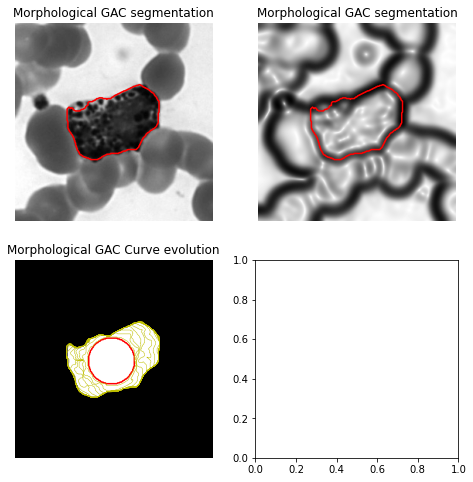

In [29]:


img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
#img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force 

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 1 ; 
Niter_snake      = 100

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto" 
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour 
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour 
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls, 
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
    
plt.show();